In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# для расчетов над tdb
from pycalphad import Database

# для MCMC расчетов
import pymc as pm  # пакет для MCMC расчетов 
import arviz as az # пакет для работы с типом данных arviz
import aesara
import scipy
import seaborn as sns

# пути к tdb
db_path = 'tdbs/CoCr-01Oik_with_new_functions.tdb'

# пути к опытным данным
path_sigma_fcc = 'emp_data/sigma_fcc_allibert.xls'
path_sigma_hcp = 'emp_data/sigma_hcp_allibert.xls'
path_bcc = 'emp_data/sigma_bcc_allibert.xls'

# подгрузка и преобразование опытных данных при концентрации хрома 0.5
df_sigma_fcc = pd.read_excel(path_sigma_fcc)
df_sigma_hcp = pd.read_excel(path_sigma_hcp)

df_hcp_fcc = pd.concat([df_sigma_fcc, df_sigma_hcp])

df_hcp_fcc['T'] = df_hcp_fcc['T'].round(2)
df_hcp_fcc['cr_conc'] = df_hcp_fcc['cr_conc'].round(6)
df_hcp_fcc = df_hcp_fcc[(df_hcp_fcc['phase'] == 'sigma_old')].reset_index()
df_hcp_fcc.sort_values('T', inplace=True)

y_obs_05 = df_hcp_fcc['cr_conc'].values
t_05 = df_hcp_fcc['T'].to_numpy()

# подгрузка и преобразование опытных данных при концентрации хрома 0.75
df_bcc = pd.read_excel(path_bcc)

df_bcc['T'] = df_bcc['T'].round(2)
df_bcc['cr_conc'] = df_bcc['cr_conc'].round(6)
df_bcc = df_bcc[(df_bcc['phase'] == 'sigma_old')].reset_index()
df_bcc.sort_values('T', inplace=True)

y_obs_75 = df_bcc['cr_conc'].values
t_75 = df_bcc['T'].to_numpy()

# подгрузка и преобразование расчетных данных 
trace = az.from_json('calc_res/trace_cocr10_2Sx700x1000x4.json')
ppc = az.from_json('calc_res/ppc_cocr10_2Sx700x1000x4.json')
pp = az.from_json('calc_res/pp_cocr10_2Sx4000.json')
main = trace.extend(ppc)
par_list = ['SIGMA_OLD_COCRCO_0', 'SIGMA_OLD_COCRCO_1', 'SIGMA_OLD_COCRCR_0', 'SIGMA_OLD_COCRCR_1']

print(f"Running on PyMC v{pm.__version__}") # 5.3.1 or 5.1.2
print(f"Running on NumPy v{np.__version__}") # 1.22.1
print(f"Running on ArviZ v{az.__version__}") # 0.12.1

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.3.1
Running on NumPy v1.22.1
Running on ArviZ v0.15.1


In [2]:
db = Database(db_path)

# График распределения цепей

array([[<Axes: title={'center': 'SIGMA_OLD_COCRCO_0'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCO_0'}>],
       [<Axes: title={'center': 'SIGMA_OLD_COCRCO_1'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCO_1'}>],
       [<Axes: title={'center': 'SIGMA_OLD_COCRCR_0'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCR_0'}>],
       [<Axes: title={'center': 'SIGMA_OLD_COCRCR_1'}>,
        <Axes: title={'center': 'SIGMA_OLD_COCRCR_1'}>]], dtype=object)

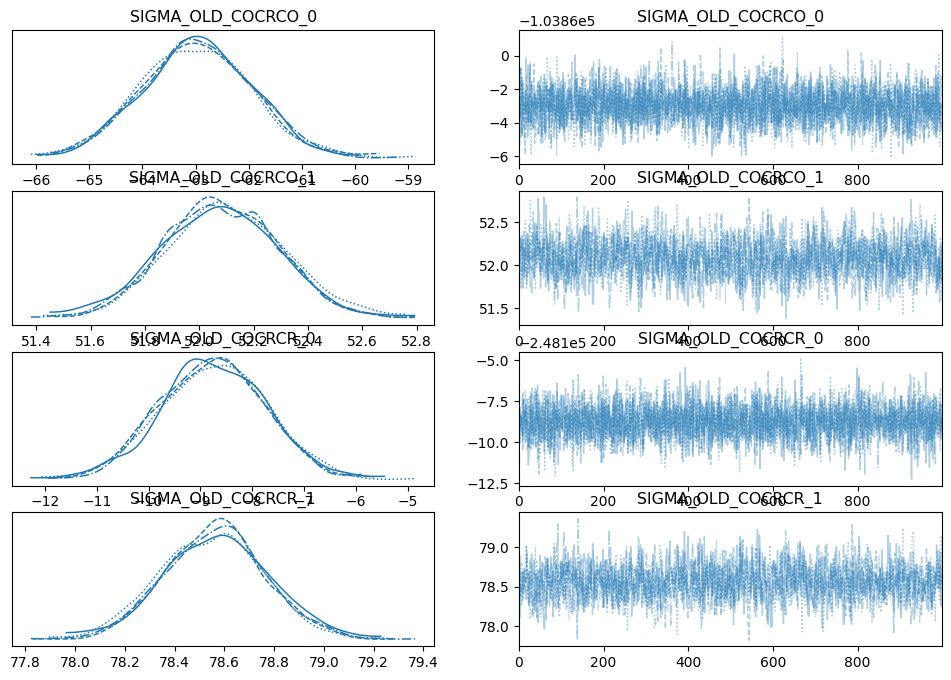

In [3]:
az.plot_trace(trace)

Статистики

In [4]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
SIGMA_OLD_COCRCO_0,-103862.971,1.035,-103864.956,-103861.104,0.017,0.012,3561.0,2760.0,1.0
SIGMA_OLD_COCRCO_1,52.085,0.215,51.685,52.489,0.006,0.004,1345.0,1994.0,1.0
SIGMA_OLD_COCRCR_0,-248108.754,1.005,-248110.596,-248106.873,0.016,0.011,4043.0,2814.0,1.0
SIGMA_OLD_COCRCR_1,78.562,0.211,78.182,78.979,0.006,0.004,1399.0,1934.0,1.0


# Вывод
Цепи достаточно информативны для проведения анализа

# График автокорреляции

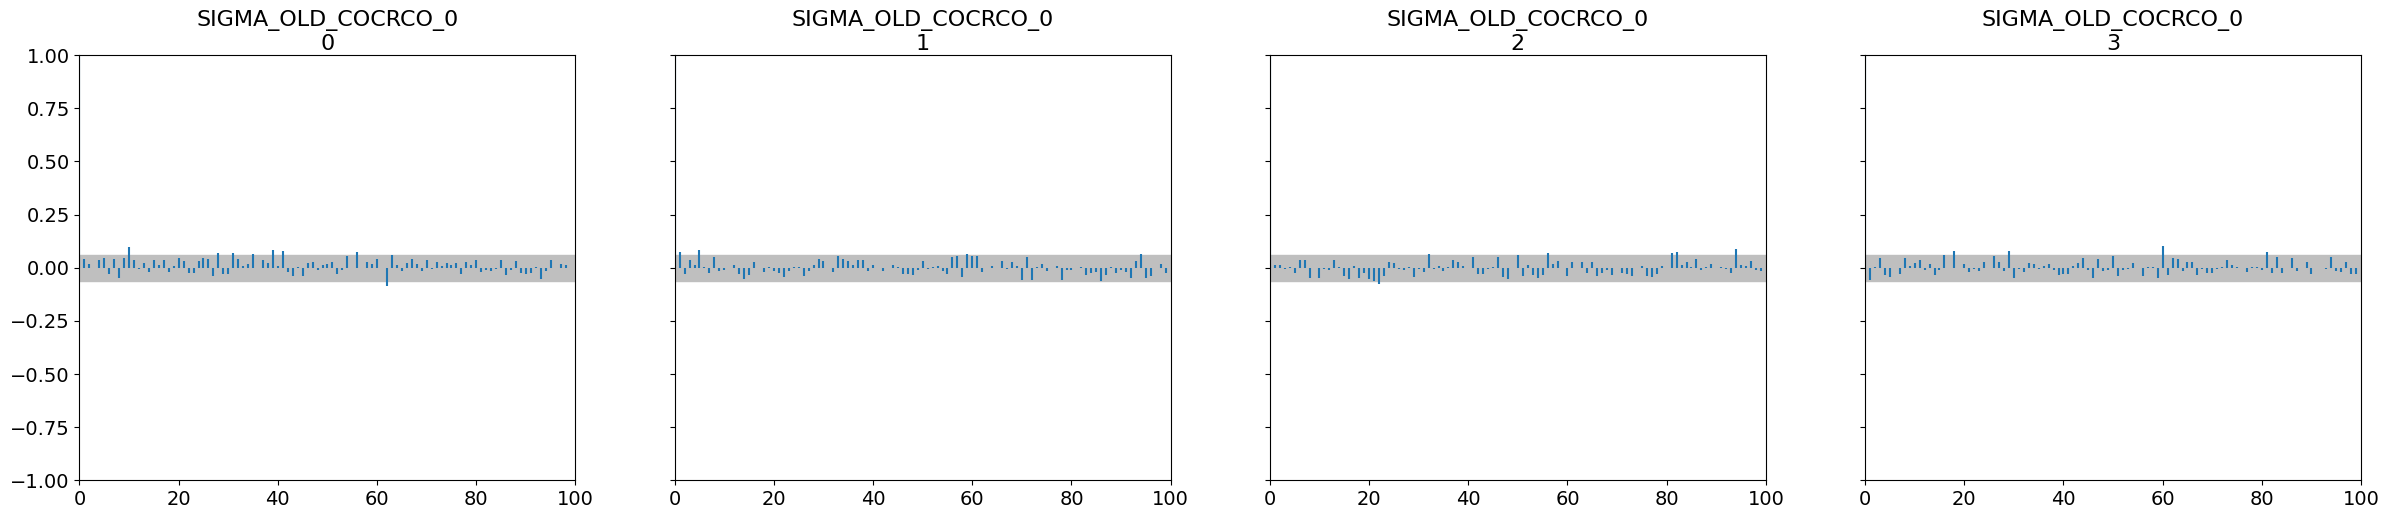

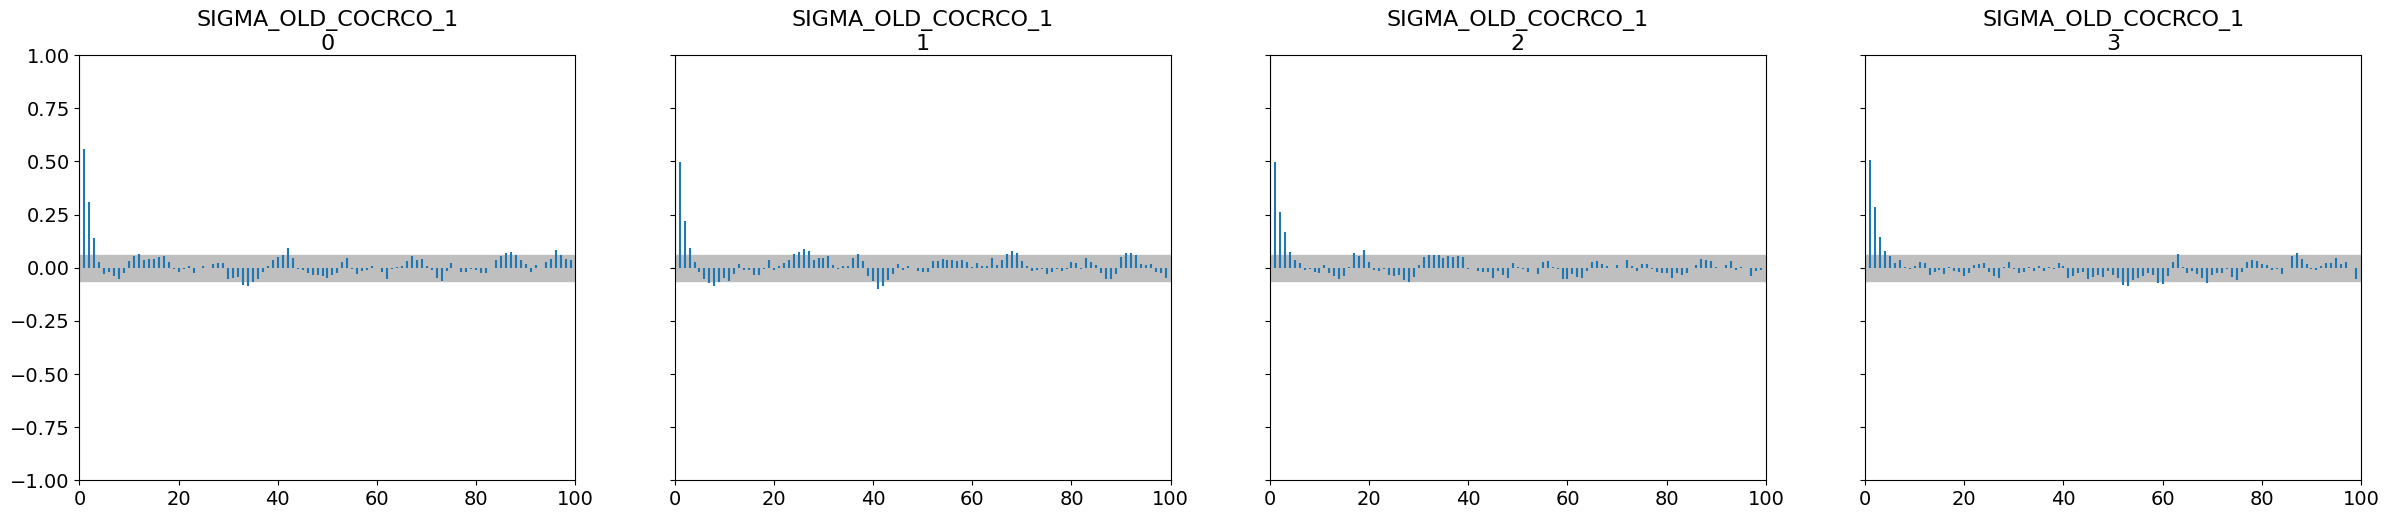

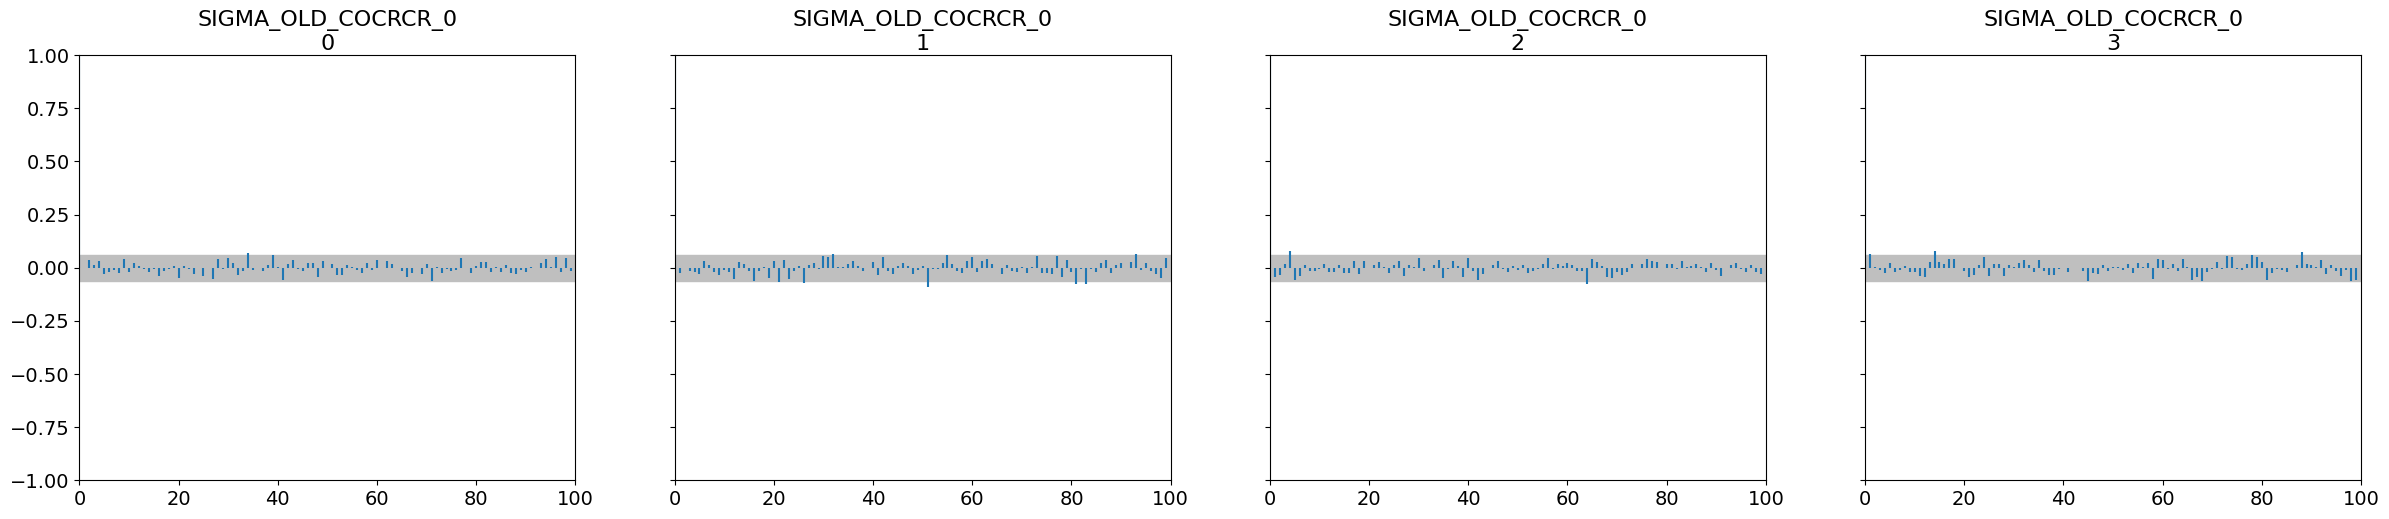

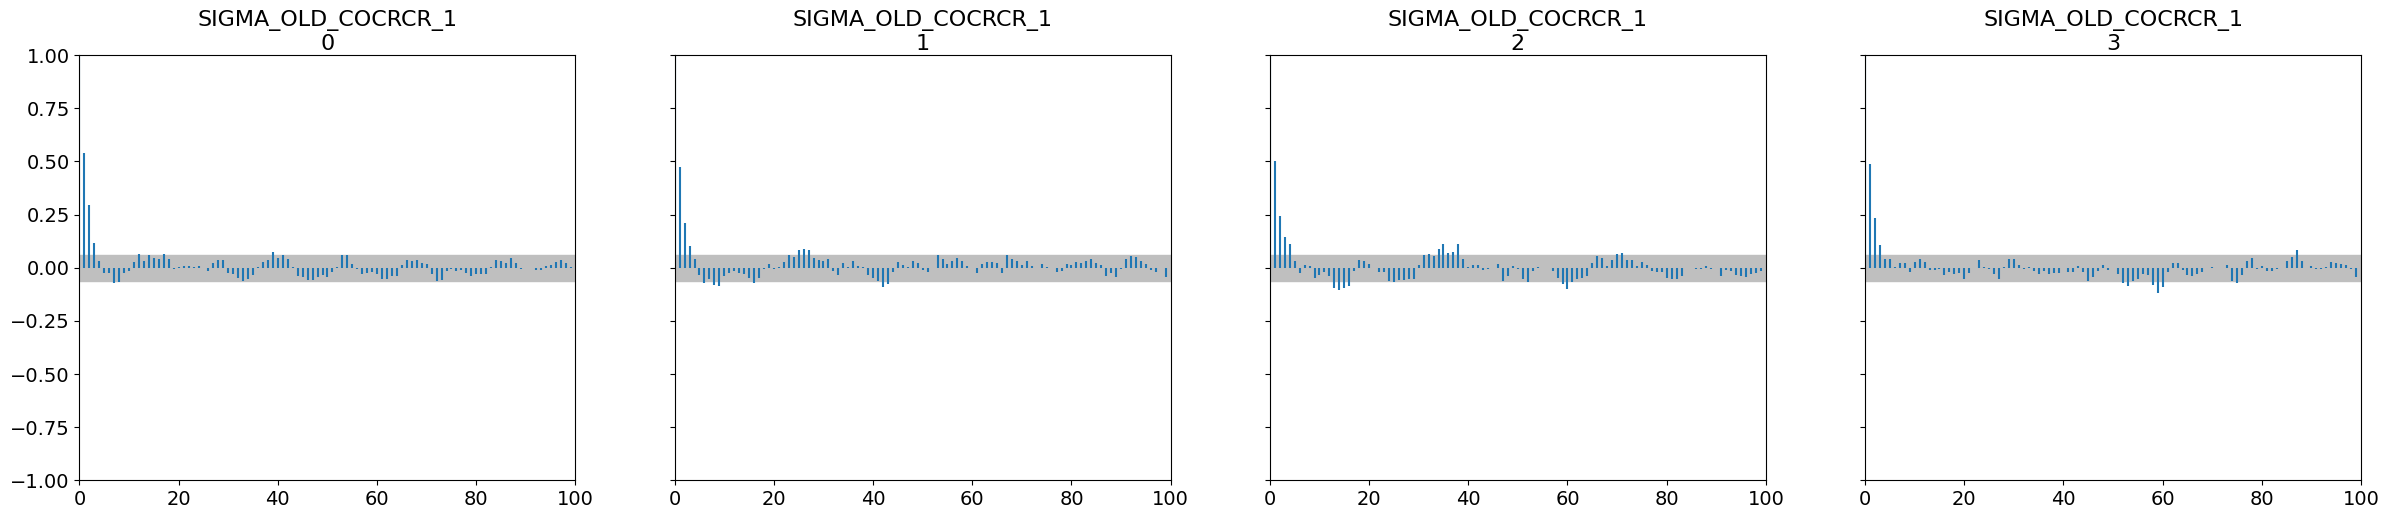

In [5]:
for par in par_list:
    az.plot_autocorr(trace, var_names = par)

# Вывод
Цепи достаточно информативны для проведения анализа

# Распределение квадратов отклонений

In [6]:
# запись словаря со значениями параметров по tdb
def from_piecewise_to_dict(db, parameters_list):
    import sympy
    full_par_dict = db.symbols
    tdb_par_dict = dict()

    for par in parameters_list:
        tdb_par_dict[par] = np.float32(full_par_dict[par].args_as_sympy()[0])
    return tdb_par_dict

# собираем цепи в одну для каждого параметра, словарь
def chains_concatenate(traces, parameters_list):
    # создаем словарь с распределениями параметров
    par_chains_dict = dict()
    for par in parameters_list:
        par_chains_dict[par] = np.float32(np.concatenate(traces.posterior.variables[par]))
    
    # вычисляем объем каждого сэмпла
    chains_num = traces.sample_stats.chain.data.shape
    draws_num = traces.sample_stats.draw.data.shape
    num_points = chains_num[0]*draws_num[0]
    
    return num_points, par_chains_dict

# для каждого распределения параметра считаем распределение квадратов отклонений от значения в tdb
def mse_dictribution_dict(par_chains_dict, tdb_par_dict, par_list):
    mse_par_dict = dict()

    for par in par_list:
        mse_par_dict[par] = np.float_power(np.subtract(par_chains_dict[par], tdb_par_dict[par]), 2)

    return mse_par_dict

def from_ppc_to_temp_dict(ppc, var_name_str):
    yt_dict = dict()
    ppc_conc = np.concatenate(ppc.posterior_predictive.data_vars[var_name_str].data)
    t_num = ppc_conc.shape[1]
    p_num = ppc_conc.shape[0]
    
    for i in range(t_num):
        i_list = []
        
        for j in range(p_num):
            i_list.append(ppc_conc[j][i])

        yt_dict[i] = i_list # key = индекс температуры в T
    return yt_dict


In [7]:
tdb_par_dict = from_piecewise_to_dict(db, par_list)
num, par_dict = chains_concatenate(trace, par_list)
mse_par_dict = mse_dictribution_dict(par_dict, tdb_par_dict, par_list)

# График распределения квадратов отклонений

Text(0.5, 1.0, 'Распределение квадратов отклонений апостериорных \n значений парамтеров от истинных занчений\n для модели из ТДБ Co-Cr10')

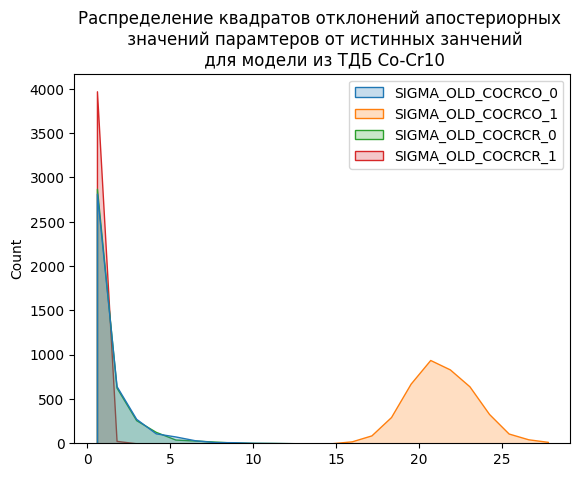

In [8]:
ax = sns.histplot(mse_par_dict, element="poly") #, kde=True element="poly"
# ax.set_ylim(0, 200)
ax.set_title('Распределение квадратов отклонений апостериорных \n значений парамтеров от истинных занчений\n для модели из ТДБ Co-Cr10')

# Вывод

В целом, все готово для того, чтобы посчитать точки, но есть параметры, которые плохо распределены, например ```SIGMA_OLD_COCRCR_1```. В этом случае можно не строить все распределение заново, а воспользоваться функция scipy, которая предскажет вероятность появления соответсвующего значения в распределении с заданной функцией плотности.

# График распределения предсказаний

In [9]:
y_norm_05_temp_dict = from_ppc_to_temp_dict(ppc, 'y_norm_05')
y_norm_75_temp_dict = from_ppc_to_temp_dict(ppc, 'y_norm_75')

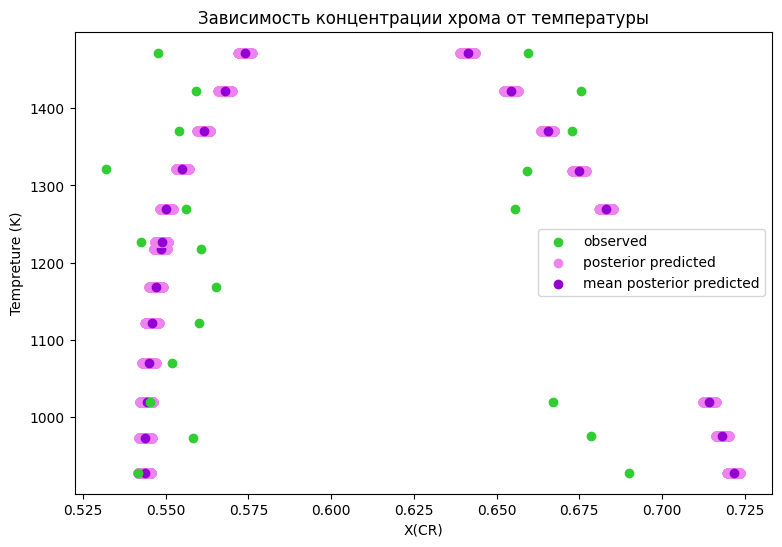

In [10]:
# Создаем фигуру и оси
fig = plt.figure(figsize=(9,6))
axes = fig.gca()

axes.set_title('Зависимость концентрации хрома от температуры')


# Добавляем точки на график и задаем метки для легенды

for i in range(len(t_05)):
    min_05 = np.percentile(y_norm_05_temp_dict[i], 2.5)
    max_05 = np.percentile(y_norm_05_temp_dict[i], 100-2.5)
    mean_05 = sum(y_norm_05_temp_dict[i])/len(y_norm_05_temp_dict[i])
    yt_05 = [x for x in y_norm_05_temp_dict[i] if x > min_05 and x < max_05]
    
    scatter2 = axes.scatter(yt_05, np.repeat(t_05[i], len(yt_05)), label='posterior predicted', color = 'violet')
    scatter3 = axes.scatter(mean_05, t_05[i], label='mean posterior predicted', color = 'darkviolet')


for i in range(len(t_75)):    
    min_75 = np.percentile(y_norm_75_temp_dict[i], 2.5)
    max_75 = np.percentile(y_norm_75_temp_dict[i], 100-2.5)
    y_75_10 = [x for x in y_norm_75_temp_dict[i] if x < 1]
    if len(y_75_10) > 0:
        yt_75 = [x for x in y_norm_75_temp_dict[i] if x > min_75 and x < max_75 and x < 1]
        mean_75 = sum(y_norm_75_temp_dict[i])/len(y_norm_75_temp_dict[i])

    
    scatter2 = axes.scatter(yt_75, np.repeat(t_75[i], len(yt_75)), label='posterior predicted', color = 'violet')
    scatter3 = axes.scatter(mean_75, t_75[i], label='mean posterior predicted', color = 'darkviolet')


scatter1 = axes.scatter(y_obs_05, t_05, label='observed', color = 'limegreen')
scatter1 = axes.scatter(y_obs_75, t_75, label='observed', color = 'limegreen')

# Добавляем легенду на график
axes.legend(handles=[scatter1, scatter2, scatter3])

# Задаем название осей
axes.set_xlabel('X(CR)')
axes.set_ylabel('Tempreture (K)')

# Отображаем график
plt.show()